In [32]:
from EnsemblePursuit.EnsemblePursuit import EnsemblePursuit
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import zscore
from scipy.ndimage import gaussian_filter, gaussian_filter1d
from sklearn.preprocessing import MinMaxScaler

In [33]:
data_path='/media/maria/DATA1/Documents/data_for_suite2p/TX39/'
dt=1
spks= np.load(data_path+'spks.npy')
print('Shape of the data matrix, neurons by timepoints:',spks.shape)
iframe = np.load(data_path+'iframe.npy') # iframe[n] is the microscope frame for the image frame n
ivalid = iframe+dt<spks.shape[-1] # remove timepoints outside the valid time range
iframe = iframe[ivalid]
S = spks[:, iframe+dt]
print(S.shape)
U=np.load('U.npy')
del spks

Shape of the data matrix, neurons by timepoints: (18795, 30766)
(18795, 30560)


(642,)


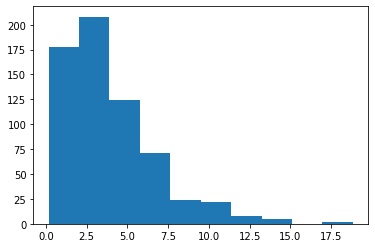

(463,)


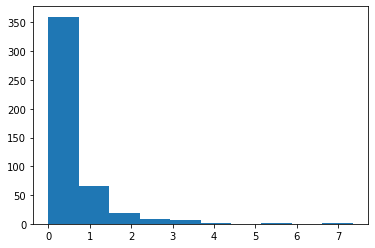

In [34]:
stim_ens_inds=np.nonzero(U[:,13])[0]
print(stim_ens_inds.shape)
stim_k=2.0
stim_theta=2.0
stim_weights=np.random.gamma(shape=stim_k,scale=stim_theta,size=(stim_ens_inds.shape[0],))
plt.hist(stim_weights)
plt.show()

beh_ens_inds=np.nonzero(U[:,8])[0]
print(beh_ens_inds.shape)
beh_k=0.5
beh_theta=1.0
beh_weights=np.random.gamma(shape=beh_k,scale=beh_theta,size=(beh_ens_inds.shape[0],))
plt.hist(beh_weights)
plt.show()

In [35]:
weights=np.hstack((stim_weights,beh_weights))
sc=MinMaxScaler()
weights=sc.fit_transform(weights.reshape(-1,1))
print(weights)

stim_inp=S[stim_ens_inds]
beh_imp=S[beh_ens_inds]
input_patterns=np.vstack((stim_inp,beh_imp))
sc=MinMaxScaler()
input_patterns=sc.fit_transform(input_patterns)

[[1.42976187e-01]
 [4.03219327e-01]
 [8.73225102e-02]
 ...
 [1.45701554e-02]
 [6.56234327e-05]
 [5.92630923e-03]]


(1105, 1)
(1105, 30560)
[[1.42976187e-01]
 [4.03219327e-01]
 [8.73225102e-02]
 ...
 [1.45701554e-02]
 [6.56234327e-05]
 [5.92630923e-03]]


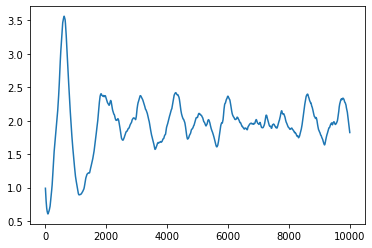

In [62]:
def gain_function(x):
        #x=np.array(x)
        #x[x<0]= 5*np.tanh(x[x<0]/5)
        '''
        if x<0:
            return 5*np.tanh(x/5)
        else:
            return (100-5)*np.tanh(x/(100-5))
        '''
        #x[x>=0]=(4000-5)*np.tanh(x[x>=0]/(4000-5))
        return x
    
def update_weights(pre_syn_activity_pattern,post_syn_activity_pattern,W,theta_BCM):
    alpha = 0.01
    #print('syn',pre_syn_activity_pattern.reshape(9479,1)@post_syn_activity_pattern.reshape(1,2))
    W+= alpha*pre_syn_activity_pattern.reshape(1105,1)*post_syn_activity_pattern.reshape(1,)@(post_syn_activity_pattern-theta_BCM)
    return W
def update_BCM_threshold(theta_BCM,activity_pattern):
    theta_BCM_dt = .01
    BCM_target = 2.0
    #print(theta_BCM)
    theta_BCM += theta_BCM_dt*((activity_pattern/BCM_target)*activity_pattern - theta_BCM)
    return theta_BCM

activity_patterns=input_patterns
theta_lst=[]
print(weights.shape)
print(activity_patterns.shape)
print(weights)
_weights=weights.flatten()
theta_BCM = 1.0
rate=np.array([[0]])
h=0.01
for t in range(0,10000):
    inpt=_weights@activity_patterns[:,t]
    #print('inp',inpt)
    dxdt=(-rate[-1]+gain_function(inpt))
    #print('dxdt',dxdt)
    rate=np.vstack((rate,(rate[-1]+h*dxdt)))
    _weights=update_weights(activity_patterns[:,t],rate[-1],_weights,theta_BCM)
    theta_BCM=update_BCM_threshold(theta_BCM,rate[-1])
    theta_lst.append(theta_BCM.item())
    
plt.plot(theta_lst)

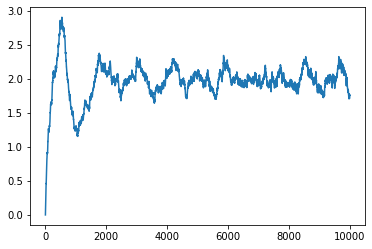

In [63]:
plt.plot(rate)